In [1]:
import mds.mds as mds
from mds.visualizationtools import add_axis_cube
from mds.rotation3sphere import spherical_to_cartesian
from hopf.hopf import hopf_fibration_inverse, localcoordsampling_2sphere

from scipy.spatial import distance
import numpy as np
import itertools as it

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import matplotlib.animation as animation

In [2]:
# helper methods for visualization
def prep_axis_basic(axis, limit=1):
    axis.set_axis_off()
    axis.set_xlim((-limit,limit))
    axis.set_ylim((-limit,limit))
    axis.set_zlim((-limit,limit))

def add_sphere_wireframe(axis):
    # drawing a translucent sphere
    # could probably also be done more elegantly via np.vectorize & spherical_to_cartesian
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    xs = np.cos(u)*np.sin(v)
    ys = np.sin(u)*np.sin(v)
    zs = np.cos(v)
    axis.plot_wireframe(xs, ys, zs, color="#0000001A")

def prep_axis_sphere(axis, limit=1):
    prep_axis_basic(axis, limit=limit)
    add_sphere_wireframe(axis)

def prep_axis_cube(axis, limit=1):
    prep_axis_basic(axis, limit=limit)
    add_axis_cube(axis, 2*limit)

def init_poly3d(verts, facecolor, edgecolor="#00000000"):
    poly = Poly3DCollection(verts)
    poly.set_facecolor(facecolor)
    poly.set_edgecolor(edgecolor)
    return poly

In [3]:
def hopf_inverse_mds(points, n_samples_fibers):
    fibers = hopf_fibration_inverse(points, n_samples_fibers)
    # unravelling sampled fibers into two arrays for indices and coordinates
    fiber_idxs, points_fibers = zip(*it.chain(*( [ (fiber_idx, point_fiber) for point_fiber in points_fiber ] for fiber_idx, points_fiber in fibers )))
    coords = list(zip(*mds.mds(points_fibers, dimensions_target=3, distance=distance.cosine)))
    return fiber_idxs, coords

In [4]:
def group_and_unravel(fiber_idxs, coords):
    for fiber_idx, fibers in it.groupby(zip(fiber_idxs,coords), key=lambda x: x[0]):
        _, fiber_coords = zip(*fibers)
        yield fiber_idx, fiber_coords

## Part 1: Collective embedding

Since the fibers are great-circles, they should simply embed into $\mathbb{R}^3$.
As a first approach, sampling from $\mathbb{S}^2$ and embedding the associated fibers all at once is attempted.

In [5]:
# sampling 30 points from S^2, i.e. plotting 30 fibers at the same time
points_base = localcoordsampling_2sphere(30)

In [6]:
fiber_idxs, coords = hopf_inverse_mds(points_base, 30)

There are 900 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 4 (0.44%)


In [7]:
verts = np.array([ list(fiber_coords) for _, fiber_coords in group_and_unravel(fiber_idxs, coords) ])

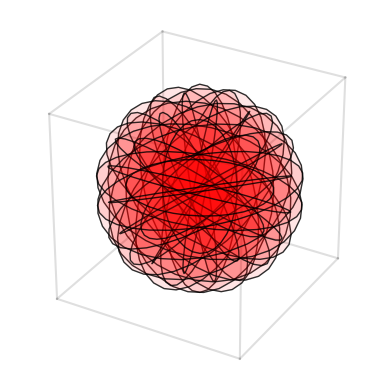

In [8]:
ax = plt.figure().add_subplot(projection='3d', box_aspect=(1,1,1))

ax.add_collection3d(init_poly3d(verts, "#ff00001A", edgecolor="#000000d0"))
prep_axis_cube(ax, limit=1)

plt.savefig("fibers-mds-collective.png", bbox_inches='tight')
plt.show()

This is obviously too cluttered.
It gives an idea of the structure, but it is impossible to see the connection between the base manifold and the fibers.
The trivial approach of simply colouring the individual fibers according to their respective points on $S^2$ seems insufficient due to how cramped the picture is.

To resolve this, an animation will be created, which allows highlighting both the current position on the *base* manifold as well as the current fiber.

## Part 2: Animation

### Full animation

As seen previously, simply drawing all fibers based on points sampled from $S^2$ is insufficient due to how quickly the image grows cluttered.
To remedy this problem, we now seek to animate the evolution of the fibers along a trajectory on $S^2$.
MDS is run on *all* fibers simultaneously.
While this incurs higher computational cost, it ensures that the relative positions of the fibers, as they are embedded, have real meaning.

To this end, a trajectory $\gamma (t)$ on $\mathbb{S}^2$ is sampled $l$ times.
At each point, $\pi^{-1}(\gamma(t_i))$ (with $i \leq l$ and $t_i$ a sampling time) is plotted, with $\pi$ the Hopf fibration.

It may already be noted that, since animations cannot be included in the writeup, two types of results are required:
(1) a smoothly animated version that can be put anywhere for demonstration, and (2) a static image that might contain shots *from* the animation with low-opacity “ghosts” of previous steps.

For ease of use, we define our trajectory as $\gamma: [0, 1] \to [0, \pi) \times [0, 2\pi)$, i.e. in spherical coordinates.

In [9]:
# Parameters

# trajectory: returns (theta, phi)-tuple
# note the factor of 4πt in the second components: the trajectory is a spiral with two full revolutions
trajectory = lambda t: (np.pi*t, 4*np.pi*t)
# positions where the trajectory is sampled
# use endpoint=False for a closed trajectory
times = np.linspace(0, 1, 50)
# number of samples for each fiber
n_samples_fibers = 20

In [10]:
traj_samples_angles = np.fromiter(map(trajectory, times), dtype=np.dtype((float, 2)))
traj_samples = np.fromiter(map(spherical_to_cartesian, traj_samples_angles), dtype=np.dtype((float, 3)))

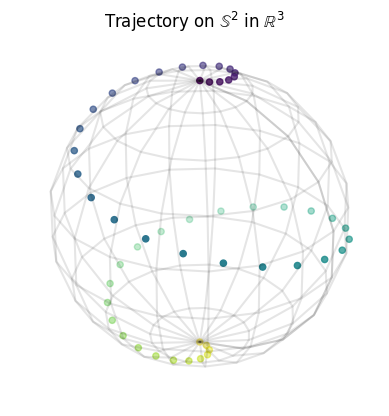

In [11]:
# note that this relies on times being in [0,1]
colors = cm.viridis(times)
ax = plt.figure().add_subplot(projection='3d', box_aspect=(1,1,1))
prep_axis_sphere(ax, limit=0.7)
x, y, z = zip(*traj_samples)
ax.scatter(x, y, z, color=colors)
ax.set_title("Trajectory on $\mathbb{S}^2$ in $\mathbb{R}^3$")

plt.show()

In [12]:
# for the animation, the entire trajectory is shown; we only want the current point to be fully opaque, all others are transparent
colors[:,3] = 0.4

In [13]:
fiber_idxs, coords = hopf_inverse_mds(traj_samples_angles, 30)

There are 1500 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 4 (0.27%)


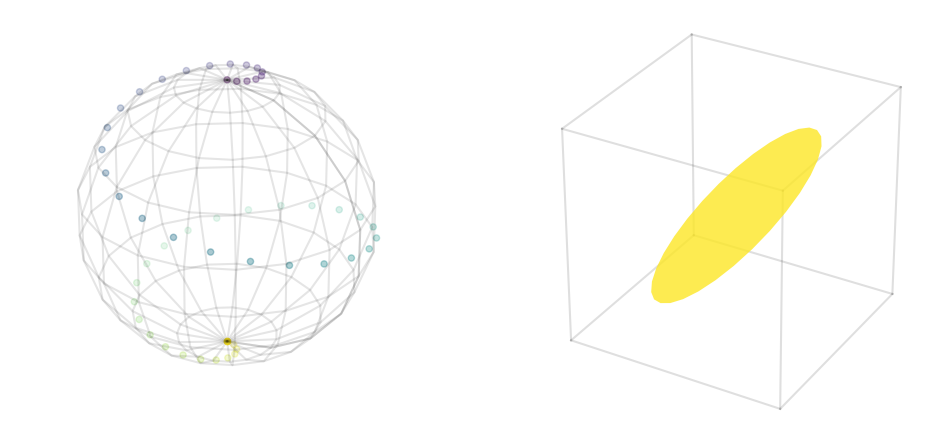

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,8), subplot_kw={"projection": '3d', "box_aspect": (1,1,1)})

prep_axis_sphere(axes[0], limit=0.8)
axes[0].scatter(x, y, z, color=colors)

prep_axis_cube(axes[1])

artists = []
for i, fiber_coords in group_and_unravel(fiber_idxs, coords):
    # scatter sampled trajectory points onto sphere
    ax0 = axes[0].scatter([x[i]], [y[i]], [z[i]], color=np.array([*colors[i][:3],1]))

    verts = np.array([list(fiber_coords)])
    # draw current fiber
    ax1 = axes[1].add_collection3d(init_poly3d(verts, np.array([*colors[i][:3],0.8])))
    
    artists.append([ax0,ax1])

ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=300)
ani.save(filename="fibers-animated.gif", writer="pillow")
plt.show()

### Static image

The next task is to produce a static image that can be embedded in the writeup. To still give an idea of the dynamic of the animation, we show translucent “ghosts” of fibers along the trajectory, previous and following.

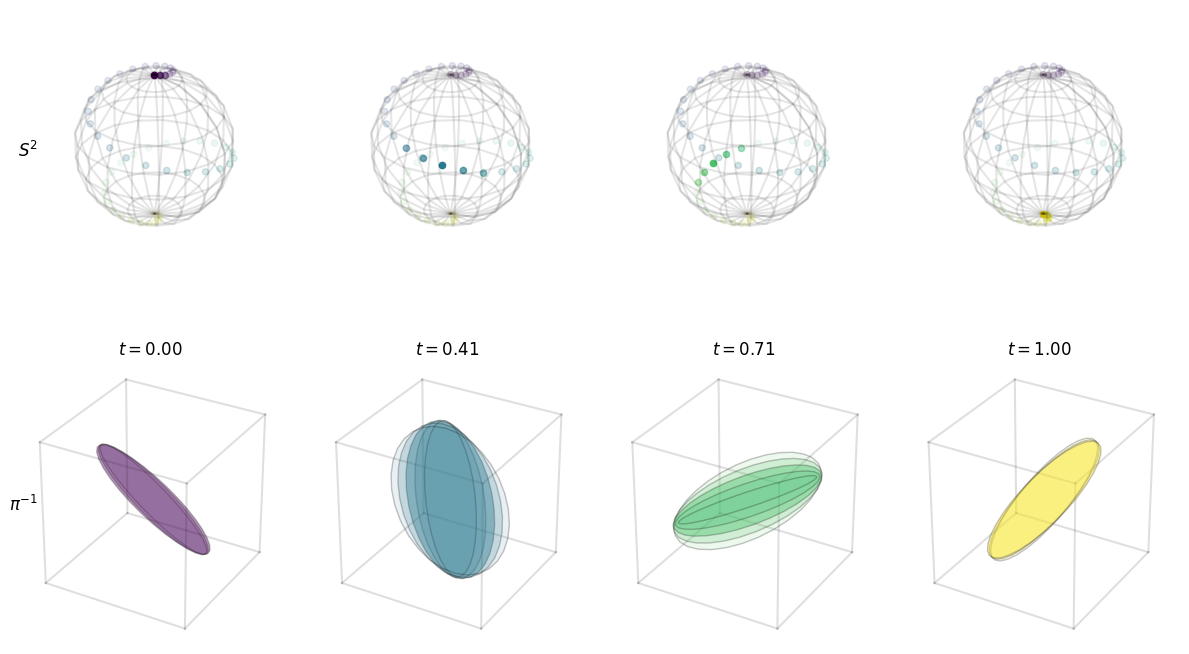

In [15]:
examples_idxs = [0, 20, 35, 49]
local_idxs = np.array([-2, -1, 0, 1, 2])
local_opacities_base = np.array([0.4, 0.6, 1.0, 0.6, 0.4])
local_opacities_fibers = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
global_opacity = 0.2

n_examples = len(examples_idxs)
fig, (axes_base, axes_fiber) = plt.subplots(2, n_examples, figsize=(12,8), subplot_kw={"projection": '3d', "box_aspect": (1,1,1)})
fig.tight_layout()

fibers_coords = [ fiber_coords for _, fiber_coords in group_and_unravel(fiber_idxs, coords) ]

for axis_base, axis_fiber, idx_main in zip(axes_base, axes_fiber, examples_idxs):
    prep_axis_sphere(axis_base)
    prep_axis_cube(axis_fiber)
    axis_fiber.set_title(f"$t={times[idx_main]:.2f}$")
    idxs = local_idxs + idx_main
    sel = (idxs >= 0) & (idxs < times.size)
    idxs = idxs[sel]

    # since alpha information is given explicitly at all later points, this is safe
    colors[:, 3] = global_opacity
    axis_base.scatter(x, y, z, color=colors)

    verts = []
    for idx, opacity in zip(idxs, local_opacities_base[sel]):
        axis_base.scatter([x[idx]], [y[idx]], [z[idx]], color=np.array([*colors[idx][:3],opacity]))
        verts.append(list(fibers_coords[idx]))
    colors_fiber = colors[idxs]
    colors_fiber[:,3] = local_opacities_fibers[sel]
    axis_fiber.add_collection3d(init_poly3d(np.array(verts), colors_fiber, edgecolor="#0000003C"))

# add labels
axes_base[0].text(-1, -1.1, 0.2, "$S^2$", horizontalalignment="right", verticalalignment="center", rotation="vertical", fontsize="large")
axes_fiber[0].text(-1, -1.1, 0.2, "$\pi^{-1}$", horizontalalignment="right", verticalalignment="center", rotation="vertical", fontsize="large")

plt.savefig("fibers-animated-ghosts.png", bbox_inches='tight', dpi=300)
plt.show()